# Align image

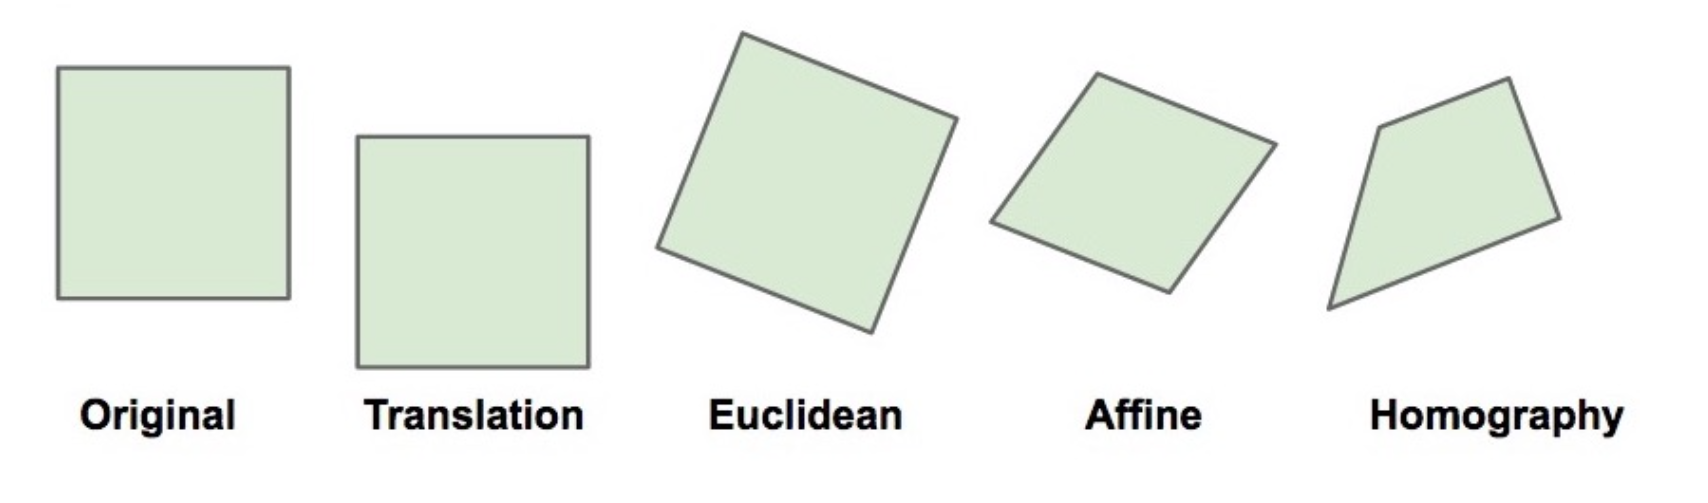

In [1]:
# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
from urllib.request import urlretrieve

In [2]:
# Create folder and unzip data
my_directory = os.path.join(os.getcwd(), 'resources', 'lesson 8')

if not os.path.exists(path=my_directory):
    os.makedirs(name=my_directory)
    
URL = r"https://www.dropbox.com/s/zuwnn6rqe0f4zgh/opencv_bootcamp_assets_NB8.zip?dl=1"
zip_file = os.path.join(my_directory, f"opencv_bootcamp_assets_NB8.zip")

try:
    urlretrieve(url=URL, filename=zip_file)  # Download zip file here
    with ZipFile(file=zip_file, mode='r') as z:
        z.extractall(my_directory)
    print('OK!')
except Exception as e:
    print(e)

OK!


In [3]:
## Step 1: Read Template and Scanned Image
reference = os.path.join(my_directory, 'form.jpg')
print('Reading reference image:', reference)
img_1 = cv2.imread(filename=reference, flags=cv2.IMREAD_COLOR)
img_1 = cv2.cvtColor(src=img_1, code=cv2.COLOR_BGR2RGB)

bad = os.path.join(my_directory, 'scanned-form.jpg')
print('Reading image to align:', bad)
img_2 = cv2.imread(filename=bad, flags=cv2.IMREAD_COLOR)
img_2 = cv2.cvtColor(src=img_2, code=cv2.COLOR_BGR2RGB)

Reading reference image: C:\Users\Alexander Kapturov\Robotics\September 2023 (month 2)\resources\lesson 8\form.jpg
Reading image to align: C:\Users\Alexander Kapturov\Robotics\September 2023 (month 2)\resources\lesson 8\scanned-form.jpg


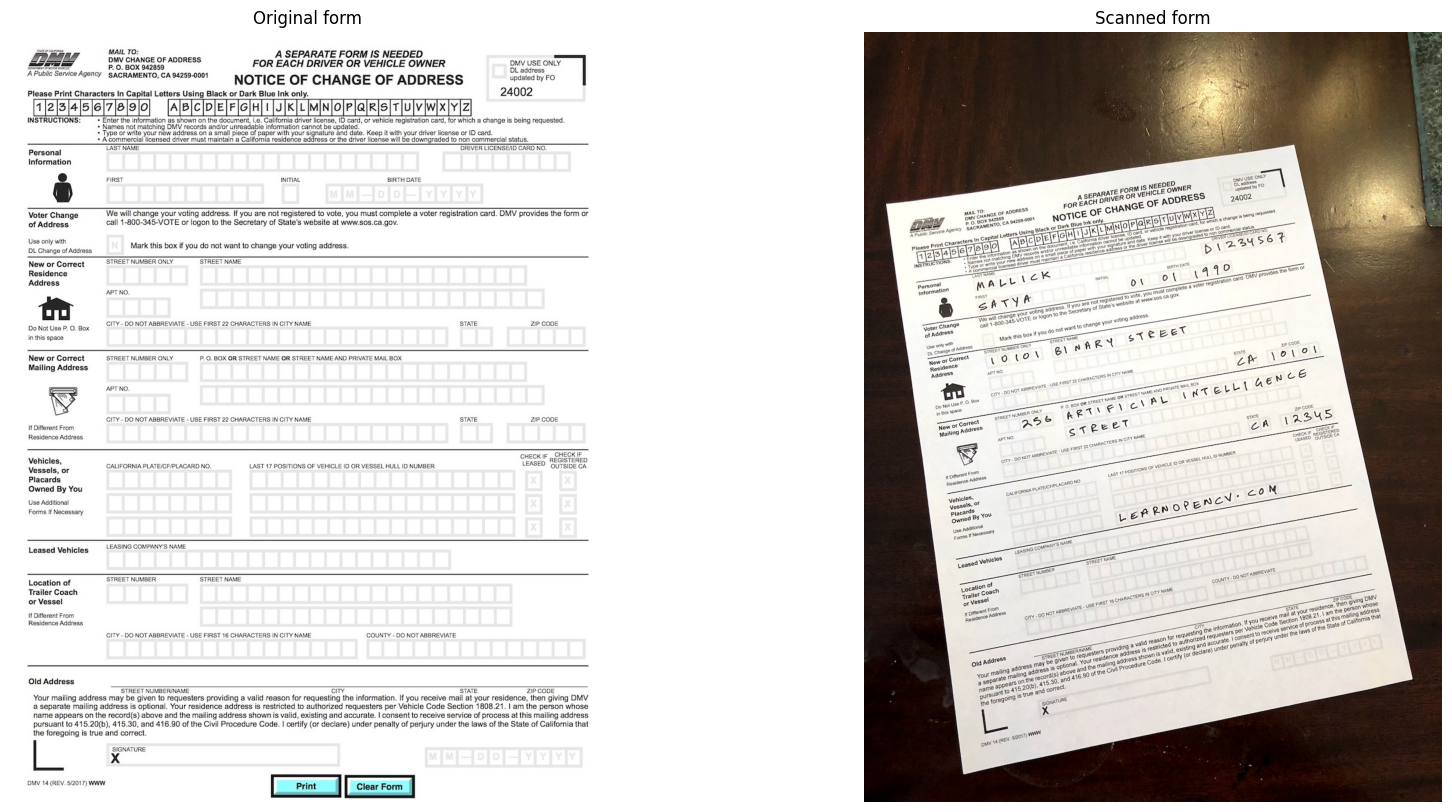

In [4]:
# Display images
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.axis('off')
plt.imshow(img_1)
plt.title('Original form')

plt.subplot(122)
plt.axis('off')
plt.imshow(img_2)
plt.title('Scanned form');

## Step 2: Find keypoints in both images

In [5]:
img1_gray = cv2.cvtColor(img_1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img_2, cv2.COLOR_BGR2GRAY)

# Detect ORB features
MAX_NUM_FEATURES = 500
orb = cv2.ORB_create(MAX_NUM_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

# Display
img_1_display = cv2.drawKeypoints(img_1, keypoints1, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_2_display = cv2.drawKeypoints(img_2, keypoints2, outImage=np.array([]), 
                                color=(255, 0, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

[Feature matching using ORB algorithm in Python-OpenCV](https://www.geeksforgeeks.org/feature-matching-using-orb-algorithm-in-python-opencv/)

[OpenCV – drawKeypoints()](https://www.geeksforgeeks.org/python-opencv-drawkeypoints-fuction/)

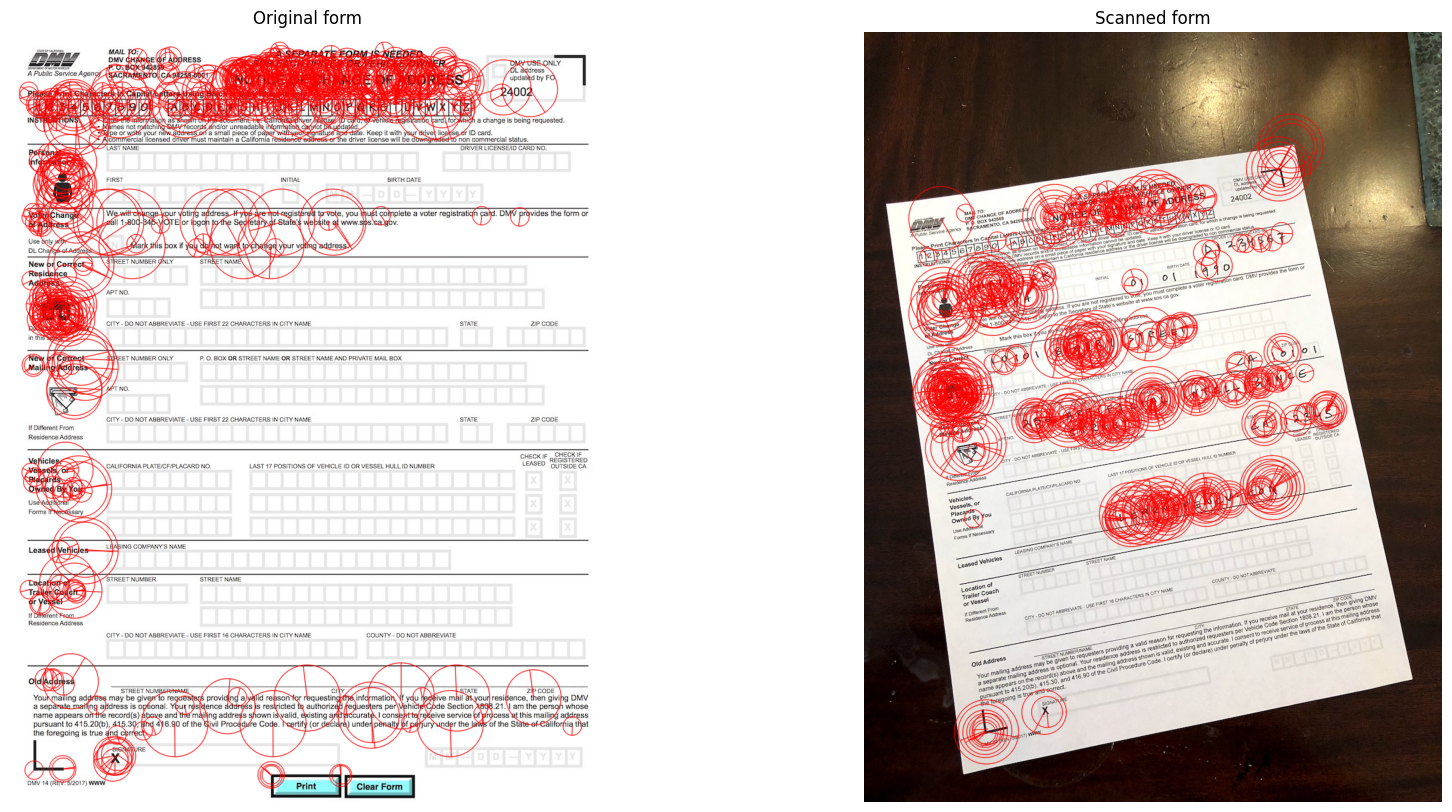

In [6]:
# Display images
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.axis('off')
plt.imshow(img_1_display)
plt.title('Original form')

plt.subplot(122)
plt.axis('off')
plt.imshow(img_2_display)
plt.title('Scanned form');

# Step 3: Match keypoints in the two images

[cv.ORB/detectAndCompute](https://amroamroamro.github.io/mexopencv/matlab/cv.ORB.detectAndCompute.html)

[cv::DescriptorMatcher Class Reference](https://docs.opencv.org/3.4/db/d39/classcv_1_1DescriptorMatcher.html)

In [7]:
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Converting to list for sorting as tuples are immutable objects
matches = list(matcher.match(descriptors1, descriptors2, None))

# Sort matches by score
matches.sort(key=lambda x: x.distance)

# Remove bad matches
bad_matches = int(len(matches) * 0.1)
matches = matches[:bad_matches]
matches

[< cv2.DMatch 0000025BBEC93050>,
 < cv2.DMatch 0000025BBEC93070>,
 < cv2.DMatch 0000025BBEC93250>,
 < cv2.DMatch 0000025BBEC93750>,
 < cv2.DMatch 0000025BBEC93830>,
 < cv2.DMatch 0000025BBEC932D0>,
 < cv2.DMatch 0000025BBEC93470>,
 < cv2.DMatch 0000025BBEC93110>,
 < cv2.DMatch 0000025BBEC93290>,
 < cv2.DMatch 0000025BBEC937F0>,
 < cv2.DMatch 0000025BBEC91F90>,
 < cv2.DMatch 0000025BBEC92690>,
 < cv2.DMatch 0000025BBEC93710>,
 < cv2.DMatch 0000025BBEC92190>,
 < cv2.DMatch 0000025BBEC92E50>,
 < cv2.DMatch 0000025BBEC93270>,
 < cv2.DMatch 0000025BBEC91ED0>,
 < cv2.DMatch 0000025BBEC934F0>,
 < cv2.DMatch 0000025BBEC931F0>,
 < cv2.DMatch 0000025BBEC933F0>,
 < cv2.DMatch 0000025BBEC92B90>,
 < cv2.DMatch 0000025BBEC93E70>,
 < cv2.DMatch 0000025BBEC927D0>,
 < cv2.DMatch 0000025BBEC92FD0>,
 < cv2.DMatch 0000025BBEC931D0>,
 < cv2.DMatch 0000025BBEC93630>,
 < cv2.DMatch 0000025BBEC928F0>,
 < cv2.DMatch 0000025BBEC93890>,
 < cv2.DMatch 0000025BBEC92B10>,
 < cv2.DMatch 0000025BBEC93530>,
 < cv2.DMa

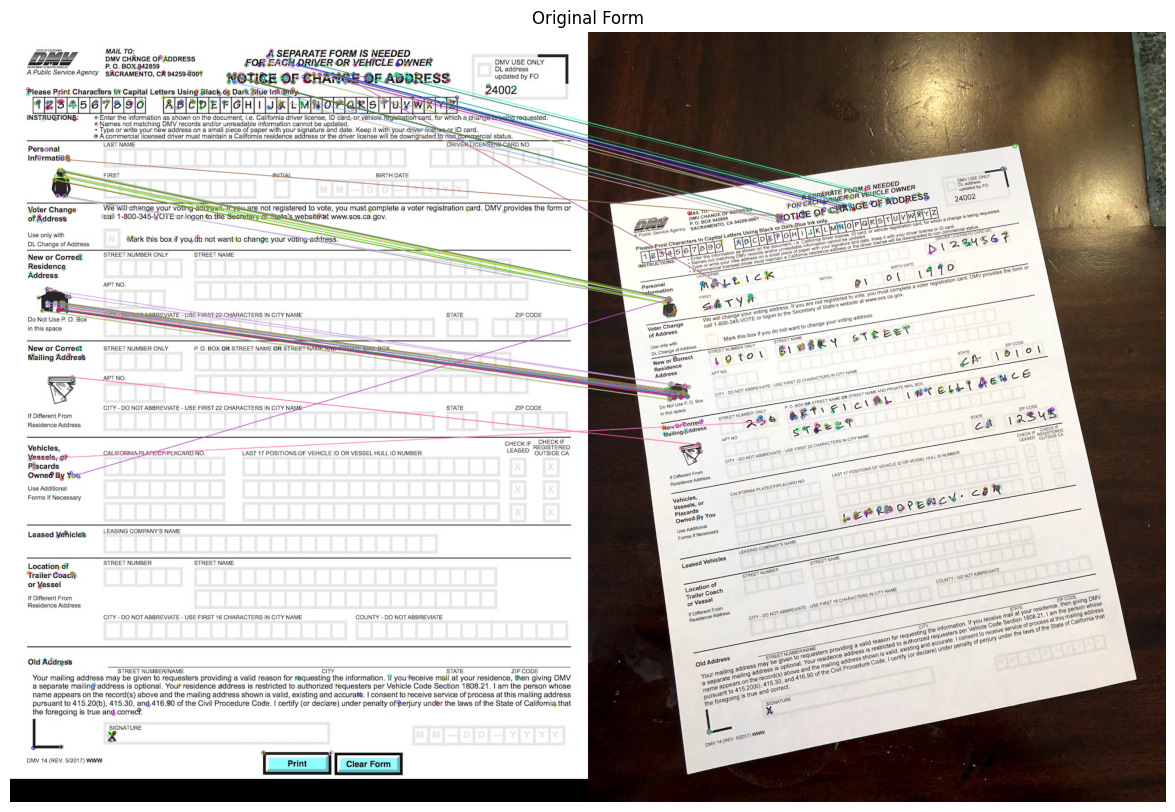

In [8]:
# Draw top matches
img_matches = cv2.drawMatches(img_1, keypoints1, img_2, keypoints2, matches, None)

plt.figure(figsize=[40, 10])
plt.imshow(img_matches)
plt.axis("off")
plt.title("Original Form");

# Step 4: Find Homography

In [9]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt
    
# Find homography
h, mask = cv2.findHomography(srcPoints=points2, dstPoints=points1, method=cv2.RANSAC)
h

array([[ 1.40692593e+00, -2.04020505e-01, -6.60865029e+00],
       [ 2.23293008e-01,  1.54696537e+00, -4.89454082e+02],
       [-6.80320989e-05,  1.58905649e-04,  1.00000000e+00]])

# Step 5: Warp image

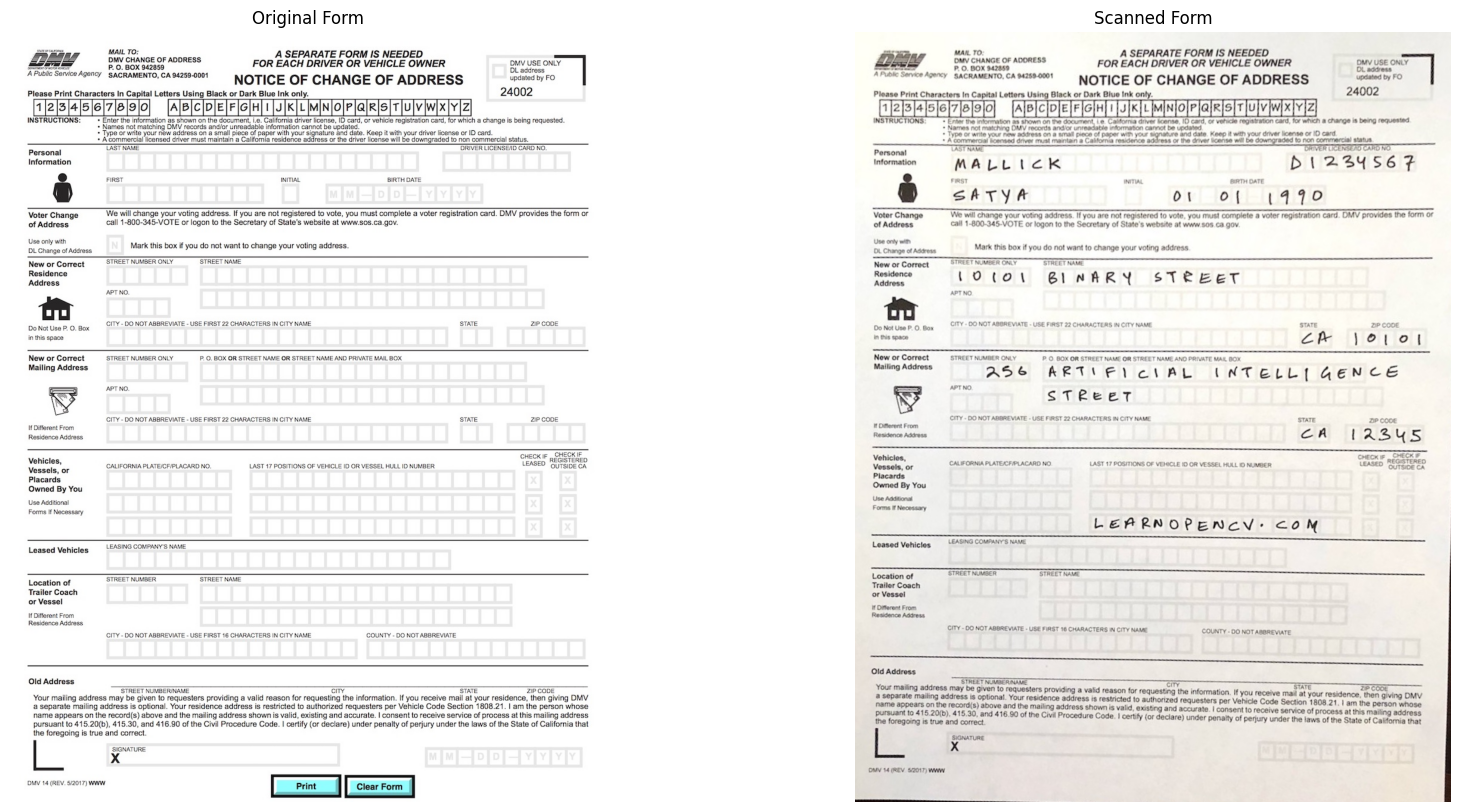

In [10]:
# Use homography to warp image
height, width, channels = img_1.shape
img_2_reg = cv2.warpPerspective(src=img_2, M=h, dsize=(width, height))

# Display results
plt.figure(figsize=[20, 10])
plt.subplot(121)
plt.imshow(img_1)   
plt.axis("off")
plt.title("Original Form")

plt.subplot(122)
plt.imshow(img_2_reg)
plt.axis("off")
plt.title("Scanned Form");